The objective of this Kernel is to show why your new engineered features might be causing overfitting or not having any impact in your score at all.

If you like this kernel, please, consider upvoting. Thanks :)

### **1. PROPOSED FEATURE ENGINEERING EXPERIMENT**

Here we are going to engineer a feature based on the difference between the Probability Density Functions (PDF) of clients with target = 1 and target = 0 in the train dataset.

This experiment will give us a 0.910 local CV, without any tunning, but 0.901 when you submit it.

#### **1.1. QUICK REVIEW: PROBABILITY DENSITY FUNCTION**

`The PDF is used to specify the probability of a random variable falling within a particular range of values, as opposed to taking an specific value. (Wikipedia)`

To understand it better, check out [wikipedia](https://en.wikipedia.org/wiki/Probability_density_function)

### **2. CALCULATING THE PDF FOR THE SANTANDER'S DATASET**

#### **2.1. COMPETITION SUMMARY AND DATASET PDF**

Our dataset is composed of 200 features and a target column specifying if a client made a specific type of transaction. Our objective in this competition is, based on the train dataset, predict in the test dataset who will also make a transfer. Let's take a look at the PDF of the features 81 and 139 for values of target = 1 and target = 0. <br>
*Note: This variable choice was arbitrary, all variables are gonna behave very similarly.*

In [1]:
#import libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#import datasts
train_df = pd.read_csv('../input/santander-customer-transaction-prediction/train.csv')
test_df = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')
full = pd.concat([train_df, test_df], sort = False)

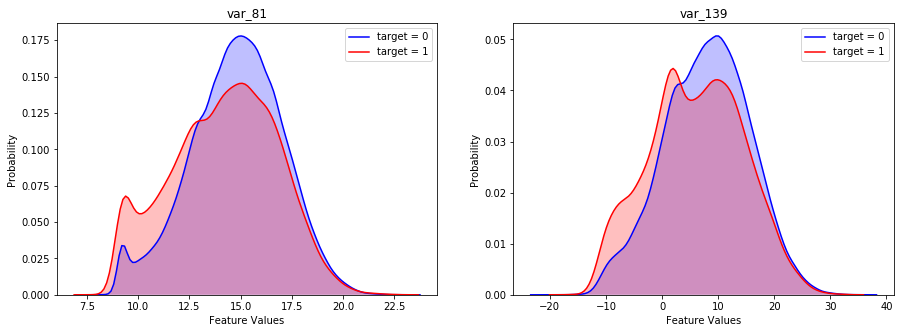

In [2]:
feat1, feat2 = 'var_81', 'var_139'

fig = plt.subplots(figsize=(15, 5))

#plot pdf feat 1
plt.subplot(1, 2, 1)
sns.kdeplot(train_df[feat1][train_df['target'] == 0], shade=True, color="b", label = 'target = 0')
sns.kdeplot(train_df[feat1][train_df['target'] == 1], shade=True, color="r", label = 'target = 1')
plt.title(feat1)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

#plot pdf feat 2
plt.subplot(1, 2, 2)
sns.kdeplot(train_df[feat2][train_df['target'] == 0], shade=True, color="b", label = 'target = 0')
sns.kdeplot(train_df[feat2][train_df['target'] == 1], shade=True, color="r", label = 'target = 1')
plt.title(feat2)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

plt.show()

As you can see, there is a great motivation to calculate the PDF difference between target = 0 and target = 1 distributions. They are clearly different, so it would make sense to say that, if pdf(target = 1) - pdf(target = 0) > 0, then there is a high probability of the client making a transfer.

#### **2.2. CREATING OUR PDF FUNCTION**

Here is the strategy used in this kernel:
- Calculate the PDF for each feature;
- Aggregate each feature values within bins;
- Use the PDF's difference between target = 0 and target = 1 for each bin as a new feature;

Notice that we could create this feature differently, by, for example, getting the target probability.

Below we will see the difference between the previously seen PDF, where the graph is very smooth, and the plot of the PDF for each bin we created.

There are 187 bins in the feature var_81
There are 201 bins in the feature var_139


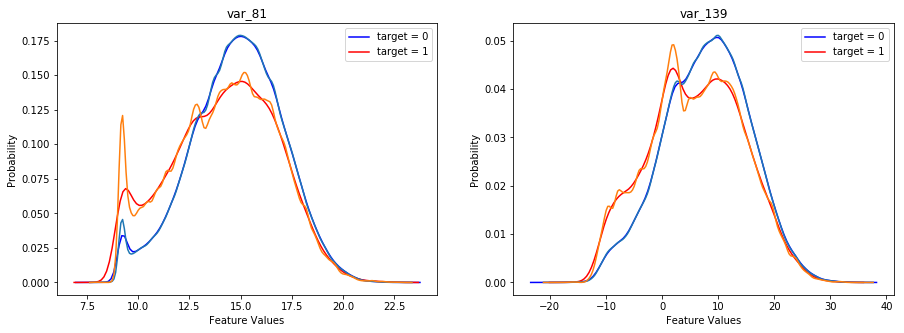

In [3]:
from sklearn.neighbors import KernelDensity
from operator import itemgetter

feat = 'var_81'

def calculate_pdf_difference(feat, df_feature, df_target, IQR_multiplier, bin_bandwidth_multiplier, print_number_bins):
    #Agreggating feature values in bin format using the Freedman-Diaconis rule
    IQR = df_feature[feat].quantile([0.75]).values - df_feature[feat].quantile([0.25]).values #Interquartile range (IQR)
    n = len(df_feature[feat])
    bin_size = IQR_multiplier*IQR/n**(1/3)
    bin_number = int(np.round((df_feature[feat].max() - df_feature[feat].min())/bin_size))
    binvalues = pd.cut(df_feature[feat], bins = bin_number, labels = range(bin_number)).astype('float')
    
    if print_number_bins:
        print('There are {} bins in the feature {}'.format(bin_number, feat))

    #Calculate the PDFs using the df_target
    pdf_0 = KernelDensity(kernel='gaussian', bandwidth=bin_size*bin_bandwidth_multiplier)
    pdf_0.fit(np.array(df_target[feat][df_target['target'] == 0]).reshape(-1,1))

    pdf_1 = KernelDensity(kernel='gaussian', bandwidth=bin_size*bin_bandwidth_multiplier)
    pdf_1.fit(np.array(df_target[feat][df_target['target'] == 1]).reshape(-1,1))

    #Creates an X array with the average feature value for each bin
    x = np.array(np.arange(min(df_feature[feat]) + bin_size/2 ,max(df_feature[feat]), bin_size)).reshape(-1,1)

    #gets the pdf values based on the X array
    log_pdf_0 = np.exp(pdf_0.score_samples(x))
    log_pdf_1 = np.exp(pdf_1.score_samples(x))

    #creates a dictionary that links the bin number with the PDFs value difference
    pdf_dict = dict()
    for i in range(bin_number):
        pdf_dict[i] = log_pdf_1[i] - log_pdf_0[i] 

    #gets the PDF difference for each row of the dataset based on its equivalent bin.
    bin_pdf_values = np.array(itemgetter(*list(binvalues))(pdf_dict))

    return bin_pdf_values, x, log_pdf_0, log_pdf_1

feat1, feat2 = 'var_81', 'var_139'

fig = plt.subplots(figsize=(15, 5))

#plot pdf feat 1
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat1, df_feature = full, df_target = train_df, IQR_multiplier = 2, bin_bandwidth_multiplier = 1.5, print_number_bins = True)

plt.subplot(1, 2, 1)

sns.kdeplot(train_df[feat1][train_df['target'] == 0], shade=False, color="b", label = 'target = 0')
sns.kdeplot(train_df[feat1][train_df['target'] == 1], shade=False, color="r", label = 'target = 1')
plt.plot(x, log_pdf_0)
plt.plot(x, log_pdf_1) 
plt.title(feat1)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

#plot pdf feat 2
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat2, df_feature = full, df_target = train_df, IQR_multiplier = 2, bin_bandwidth_multiplier = 1.5, print_number_bins = True)

plt.subplot(1, 2, 2)
sns.kdeplot(train_df[feat2][train_df['target'] == 0], shade=False, color="b", label = 'target = 0')
sns.kdeplot(train_df[feat2][train_df['target'] == 1], shade=False, color="r", label = 'target = 1')
plt.plot(x, log_pdf_0)
plt.plot(x, log_pdf_1) 
plt.title(feat2)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

plt.show()


### **3. UNDERSTANDING OVERFITTING**

The difference of smoothness on the graph above is caused by the IQR_multiplier and the bin_bandwidth_multiplier parameters.

**IQR_multiplier**<br>
IQR stands for Inter-Quartile Range and is used to define the number of bins for our distribution. This parameter is proportional to the bin size. A bigger IQR_multiplier will yield a bigger bin size and, therefore, less bins per distribution.

**bin_bandwidth_multiplier**<br>
The bandwidth value is used to smooth the graph

Let's see how the PDFs behaves as we play with those parameters

-----------------------------------------------
IQR_multiplier 0.5
bin_bandwidth_multiplier 0.2
-----------------------------------------------
There are 749 bins in the feature var_81
There are 803 bins in the feature var_139


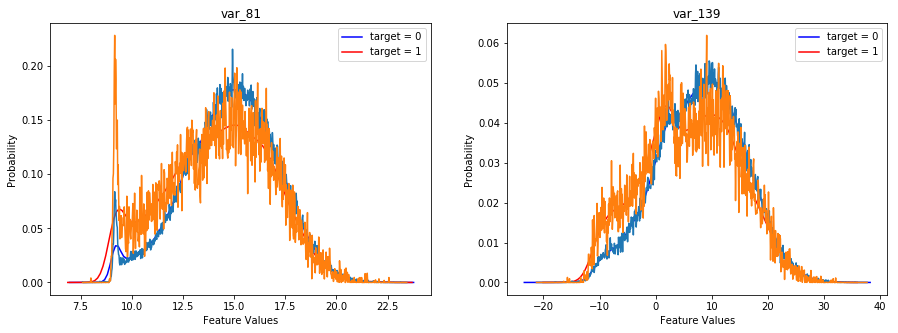

-----------------------------------------------
IQR_multiplier 5
bin_bandwidth_multiplier 0.2
-----------------------------------------------
There are 75 bins in the feature var_81
There are 80 bins in the feature var_139


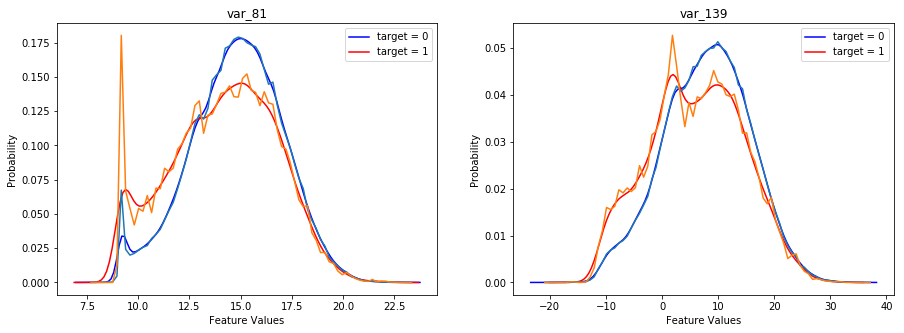

-----------------------------------------------
IQR_multiplier 3
bin_bandwidth_multiplier 0.2
-----------------------------------------------
There are 125 bins in the feature var_81
There are 134 bins in the feature var_139


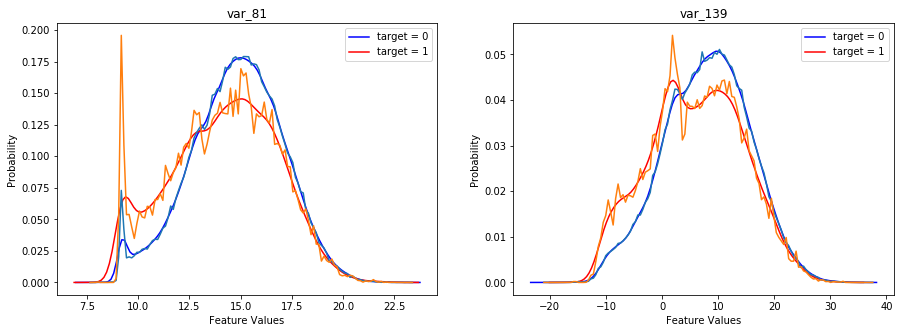

-----------------------------------------------
IQR_multiplier 3
bin_bandwidth_multiplier 3
-----------------------------------------------
There are 125 bins in the feature var_81
There are 134 bins in the feature var_139


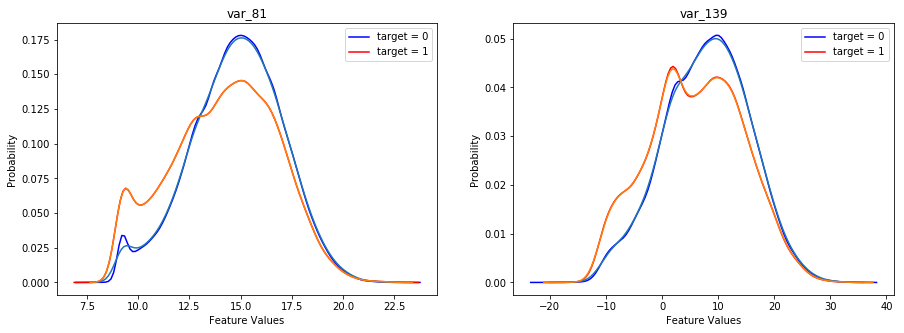

In [4]:
feat1, feat2 = 'var_81', 'var_139'



print('-----------------------------------------------')
IQR_multiplier = 0.5
bin_bandwidth_multiplier = 0.2
print('IQR_multiplier', IQR_multiplier)
print('bin_bandwidth_multiplier', bin_bandwidth_multiplier)
print('-----------------------------------------------')
fig = plt.subplots(figsize=(15, 5))
#plot pdf feat 1
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat1, df_feature = full, df_target = train_df, IQR_multiplier = IQR_multiplier, bin_bandwidth_multiplier = bin_bandwidth_multiplier, print_number_bins = True)

plt.subplot(1, 2, 1)

sns.kdeplot(train_df[feat1][train_df['target'] == 0], shade=False, color="b", label = 'target = 0')
sns.kdeplot(train_df[feat1][train_df['target'] == 1], shade=False, color="r", label = 'target = 1')
plt.plot(x, log_pdf_0)
plt.plot(x, log_pdf_1) 
plt.title(feat1)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

#plot pdf feat 2
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat2, df_feature = full, df_target = train_df, IQR_multiplier = IQR_multiplier, bin_bandwidth_multiplier = bin_bandwidth_multiplier, print_number_bins = True)

plt.subplot(1, 2, 2)
sns.kdeplot(train_df[feat2][train_df['target'] == 0], shade=False, color="b", label = 'target = 0')
sns.kdeplot(train_df[feat2][train_df['target'] == 1], shade=False, color="r", label = 'target = 1')
plt.plot(x, log_pdf_0)
plt.plot(x, log_pdf_1) 
plt.title(feat2)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

plt.show()

print('-----------------------------------------------')
IQR_multiplier = 5
bin_bandwidth_multiplier = 0.2
print('IQR_multiplier', IQR_multiplier)
print('bin_bandwidth_multiplier', bin_bandwidth_multiplier)
print('-----------------------------------------------')
fig = plt.subplots(figsize=(15, 5))
#plot pdf feat 1
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat1, df_feature = full, df_target = train_df, IQR_multiplier = IQR_multiplier, bin_bandwidth_multiplier = bin_bandwidth_multiplier, print_number_bins = True)

plt.subplot(1, 2, 1)

sns.kdeplot(train_df[feat1][train_df['target'] == 0], shade=False, color="b", label = 'target = 0')
sns.kdeplot(train_df[feat1][train_df['target'] == 1], shade=False, color="r", label = 'target = 1')
plt.plot(x, log_pdf_0)
plt.plot(x, log_pdf_1) 
plt.title(feat1)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

#plot pdf feat 2
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat2, df_feature = full, df_target = train_df, IQR_multiplier = IQR_multiplier, bin_bandwidth_multiplier = bin_bandwidth_multiplier, print_number_bins = True)

plt.subplot(1, 2, 2)
sns.kdeplot(train_df[feat2][train_df['target'] == 0], shade=False, color="b", label = 'target = 0')
sns.kdeplot(train_df[feat2][train_df['target'] == 1], shade=False, color="r", label = 'target = 1')
plt.plot(x, log_pdf_0)
plt.plot(x, log_pdf_1) 
plt.title(feat2)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

plt.show()

print('-----------------------------------------------')
IQR_multiplier = 3
bin_bandwidth_multiplier = 0.2
print('IQR_multiplier', IQR_multiplier)
print('bin_bandwidth_multiplier', bin_bandwidth_multiplier)
print('-----------------------------------------------')

fig = plt.subplots(figsize=(15, 5))

#plot pdf feat 1
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat1, df_feature = full, df_target = train_df, IQR_multiplier = IQR_multiplier, bin_bandwidth_multiplier = bin_bandwidth_multiplier, print_number_bins = True)

plt.subplot(1, 2, 1)

sns.kdeplot(train_df[feat1][train_df['target'] == 0], shade=False, color="b", label = 'target = 0')
sns.kdeplot(train_df[feat1][train_df['target'] == 1], shade=False, color="r", label = 'target = 1')
plt.plot(x, log_pdf_0)
plt.plot(x, log_pdf_1) 
plt.title(feat1)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

#plot pdf feat 2
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat2, df_feature = full, df_target = train_df, IQR_multiplier = IQR_multiplier, bin_bandwidth_multiplier = bin_bandwidth_multiplier, print_number_bins = True)

plt.subplot(1, 2, 2)
sns.kdeplot(train_df[feat2][train_df['target'] == 0], shade=False, color="b", label = 'target = 0')
sns.kdeplot(train_df[feat2][train_df['target'] == 1], shade=False, color="r", label = 'target = 1')
plt.plot(x, log_pdf_0)
plt.plot(x, log_pdf_1) 
plt.title(feat2)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

plt.show()

print('-----------------------------------------------')
IQR_multiplier = 3
bin_bandwidth_multiplier = 3
print('IQR_multiplier', IQR_multiplier)
print('bin_bandwidth_multiplier', bin_bandwidth_multiplier)
print('-----------------------------------------------')

fig = plt.subplots(figsize=(15, 5))


#plot pdf feat 1
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat1, df_feature = full, df_target = train_df, IQR_multiplier = IQR_multiplier, bin_bandwidth_multiplier = bin_bandwidth_multiplier, print_number_bins = True)

plt.subplot(1, 2, 1)

sns.kdeplot(train_df[feat1][train_df['target'] == 0], shade=False, color="b", label = 'target = 0')
sns.kdeplot(train_df[feat1][train_df['target'] == 1], shade=False, color="r", label = 'target = 1')
plt.plot(x, log_pdf_0)
plt.plot(x, log_pdf_1) 
plt.title(feat1)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

#plot pdf feat 2
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat2, df_feature = full, df_target = train_df, IQR_multiplier = IQR_multiplier, bin_bandwidth_multiplier = bin_bandwidth_multiplier, print_number_bins = True)

plt.subplot(1, 2, 2)
sns.kdeplot(train_df[feat2][train_df['target'] == 0], shade=False, color="b", label = 'target = 0')
sns.kdeplot(train_df[feat2][train_df['target'] == 1], shade=False, color="r", label = 'target = 1')
plt.plot(x, log_pdf_0)
plt.plot(x, log_pdf_1) 
plt.title(feat2)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

plt.show()


When you describe your data with a high number of bins and a low smoothing parameter, you get really "noisy" PDF, because your pool of candidates for each bin is too small and specific. This is the opposite of what we want for a robust solution.

When we use this model to predict the target on the test dataset, it will overfit, not because the datasets are way too different, but because you didn't give the model any chance to adapt for small changes.

To prove that to you, let's check the test dataset distribution

#### **3.1. THE TEST DATASET**

Here we are going to plot the target = 1 and target = 0 for the train and test dataset in the same graph.

To do that, we will get the submission with score 0.901 shared [here](https://www.kaggle.com/darbin/clustering-blender-of-0-901-solutions) and say that the 20098 highest probabilities (same number of target = 1 in the train_df) are equivalent to target = 1 in the test_df. Everything else will be set as target = 0.

In [5]:
#defines the test_df target columns based on a submission of score 0.901
pd.options.mode.chained_assignment = None  # disables copy warning from pandas library. default='warn'
submission = pd.read_csv('../input/submission-0901/submission_0901.csv')
test_df['target'] = submission['target']
test_df.sort_values('target', ascending = False, inplace = True)
test_df['target'].iloc[:20098] = 1
test_df['target'].iloc[20098:] = 0

First, let's plot the smoothed PDFs to see if there is any significant difference

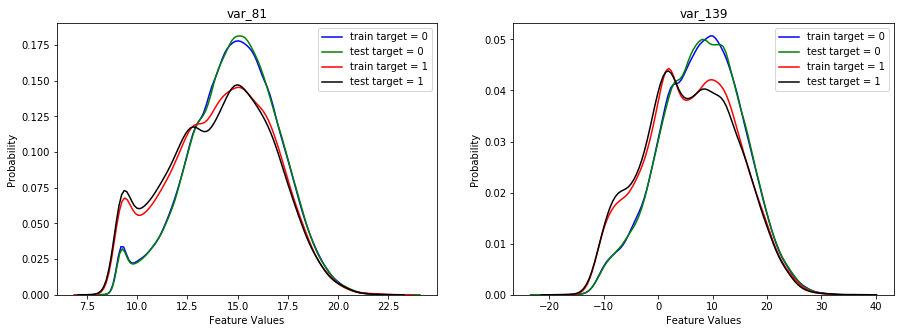

In [6]:
feat1, feat2 = 'var_81', 'var_139'

fig = plt.subplots(figsize=(15, 5))

#plot pdf feat 1
plt.subplot(1, 2, 1)
sns.kdeplot(train_df[feat1][train_df['target'] == 0], shade=False, color="b", label = 'train target = 0')
sns.kdeplot(test_df[feat1][test_df['target'] == 0], shade=False, color="g", label = 'test target = 0')
sns.kdeplot(train_df[feat1][train_df['target'] == 1], shade=False, color="r", label = 'train target = 1')
sns.kdeplot(test_df[feat1][test_df['target'] == 1], shade=False, color="k", label = 'test target = 1')
plt.title(feat1)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

#plot pdf feat 2
plt.subplot(1, 2, 2)
sns.kdeplot(train_df[feat2][train_df['target'] == 0], shade=False, color="b", label = 'train target = 0')
sns.kdeplot(test_df[feat2][test_df['target'] == 0], shade=False, color="g", label = 'test target = 0')
sns.kdeplot(train_df[feat2][train_df['target'] == 1], shade=False, color="r", label = 'train target = 1')
sns.kdeplot(test_df[feat2][test_df['target'] == 1], shade=False, color="k", label = 'test target = 1')
plt.title(feat2)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

plt.show()

There is a small, but still significant difference in the distribution of target = 1. Now, let's see how big is this difference when we don't smooth the PDF.

-----------------------------------------------
IQR_multiplier 3
bin_bandwidth_multiplier 0.2
-----------------------------------------------
There are 125 bins in the feature var_81
There are 134 bins in the feature var_139


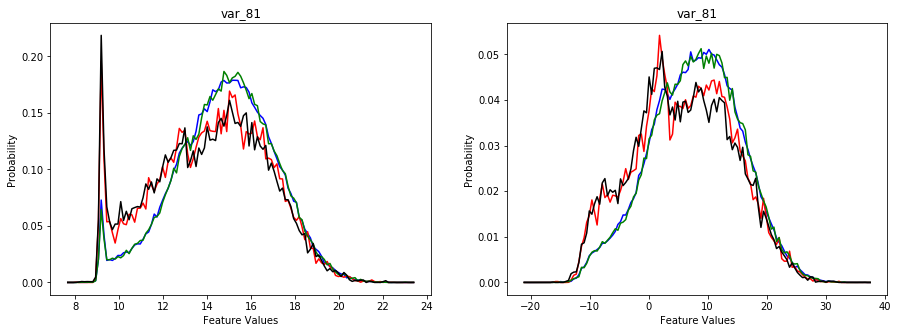

In [7]:
print('-----------------------------------------------')
IQR_multiplier = 3
bin_bandwidth_multiplier = 0.2
print('IQR_multiplier', IQR_multiplier)
print('bin_bandwidth_multiplier', bin_bandwidth_multiplier)
print('-----------------------------------------------')

fig = plt.subplots(figsize=(15, 5))


#plot pdf feat 1


plt.subplot(1, 2, 1)

bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat1, df_feature = full, df_target = train_df, IQR_multiplier = IQR_multiplier, bin_bandwidth_multiplier = bin_bandwidth_multiplier, print_number_bins = True)
plt.plot(x, log_pdf_0, 'b', label = 'train target = 0')
plt.plot(x, log_pdf_1, 'r', label = 'train target = 1')
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat1, df_feature = full, df_target = test_df, IQR_multiplier = IQR_multiplier, bin_bandwidth_multiplier = bin_bandwidth_multiplier, print_number_bins = False)
plt.plot(x, log_pdf_0, 'g', label = 'test target = 0')
plt.plot(x, log_pdf_1, 'k', label = 'test target = 1')
plt.title(feat1)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

#plot pdf feat 2
plt.subplot(1, 2, 2)
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat2, df_feature = full, df_target = train_df, IQR_multiplier = IQR_multiplier, bin_bandwidth_multiplier = bin_bandwidth_multiplier, print_number_bins = True)
plt.plot(x, log_pdf_0, 'b', label = 'train target = 0')
plt.plot(x, log_pdf_1, 'r', label = 'train target = 1')
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat2, df_feature = full, df_target = test_df, IQR_multiplier = IQR_multiplier, bin_bandwidth_multiplier = bin_bandwidth_multiplier, print_number_bins = False)
plt.plot(x, log_pdf_0, 'g', label = 'test target = 0')
plt.plot(x, log_pdf_1, 'k', label = 'test target = 1')
plt.title(feat1)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

plt.show()

As you can see, every point representing a bin has a different PDF for train_df and test_df. Expecting that their distributions will match is equivalent of what is happening in the image below:

You can find [here](https://hackernoon.com/memorizing-is-not-learning-6-tricks-to-prevent-overfitting-in-machine-learning-820b091dc42) the article about over/underfitting from where this image was taken.
![overfitting](https://raw.githubusercontent.com/fmellomascarenhas/Kaggle---Why-your-model-is-overfitting/master/1_SBUK2QEfCP-zvJmKm14wGQ.png) 

I hope that these graphs can make it clear why your model overfits when you are too specific about a single variable, instead of a group of variables.

A good question here would be: What happens if I use this feature with smoothed values? Well, the smoothier it is, the lesser the impact on your score, and here is why.

### **4. HOW THE ALGORITHM WORKS AND WHY MY FEATURES DON'T POSITIVELY IMPACT IT**

LGB, catboost and XGBoost are tree based algorithms. Each of them has their specificity, but let's try to understand the main concept behind it.

#### **4.1. TREE BASED ALGORITHM**

![Decision trees](https://raw.githubusercontent.com/fmellomascarenhas/Kaggle---Why-your-model-is-overfitting/master/Screenshot%20from%202019-04-05%2018-49-51.png) <center> *source: superdatascience* </center>

Those algorithms work by finding the best places to split your data in each dimension/axis, so you can find groups that better represent a target based on the mean value of that group. Parameter tunning has a great whole here, for example: If you do too many splits, then you will overfit, because you won't be getting the average result of a relevant number of points per split.

To understand better how the algorithm is making those splits, check out this code shared by Chris Deotte [here](https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/87133#502814).


AUC =  0.6046


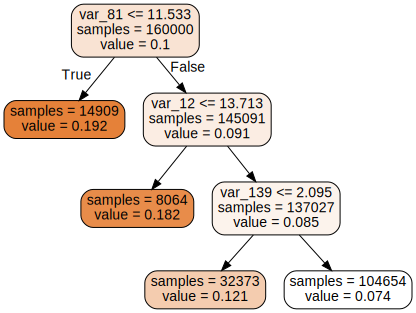

In [8]:
from sklearn.metrics import roc_auc_score
from sklearn import tree
import graphviz

cols = [c for c in train_df.columns if (c not in ['ID_code', 'target'])]

valid = train_df.sample(frac=0.2, random_state=42)
train = train_df[ ~train_df.index.isin(valid.index) ].sample(frac=1)

#model = tree.DecisionTreeClassifier(max_leaf_nodes=4)
model = tree.DecisionTreeRegressor(max_leaf_nodes=4)
model.fit(train[cols], train['target'])
#pred_val = model.predict_proba(valid[cols])[:,1]
pred_val = model.predict(valid[cols])

print('AUC = ',round( roc_auc_score(valid['target'],pred_val),4 ) )
tree_graph = tree.export_graphviz(model, out_file=None, max_depth = 10,
    impurity = False, feature_names = cols, class_names = ['0', '1'],
    rounded = True, filled= True )
graphviz.Source(tree_graph)  

#### **4.2. CALCULATING SOMETHING THE MODEL ALREADY DOES**

Features engineered based on mean values, for example, are worthless when using tree based algorithms. They already calculate it, and probably in a way better than you do, because they compare different ways to split the data so that the result is not biased. The same thing happens for:
- Scaling the data;
- Calculating the probability of something based on the region where your variable is;
- Telling the algorithm where the bumps of frequency are.

There is a good discussion [here](https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/87486#latest-506429) and [here](https://www.youtube.com/watch?v=iRwf7wIfEoI&list=PLpQWTe-45nxL3bhyAJMEs90KF_gZmuqtm&index=9) about things that the models "can't see".

### **5. SUMMARY**

In this kernel we saw:
- How your new engineered features might be overfitting because your are being to specific about the target value; 
- How they might not have any impact because you are telling the model something it already knows;

Good luck on your feature engineering journey and, please, if you found this kernel interesting, consider upvoting, since it took effort and time to make it. Thank you :)